In [1]:
import sys
import numpy as np
import pandas as pd 
import tensorflow
import tensorflow.compat.v2 as tf
import matplotlib.pyplot as plt 
%matplotlib inline
tensorflow.compat.v1.logging.set_verbosity(tensorflow.compat.v1.logging.ERROR)
sys.path.append("/home/mindy/Documents/projects/creditCardFraud/SupervisedLearning/scripts/")

In [2]:
from util import *
from NN_util import *
%load_ext autoreload
%autoreload 2

In [3]:
# make sure GPU is running 
tf.test.gpu_device_name()
set_gpu_limit(7.5)

### Import the same process data from anomaly detection
* feature scale among columns are relatively close so it won't affect gradient descent as much

In [4]:
train = pd.read_csv("../../AnomalyDetection/processedData/TrainingData_normal.csv")
dev = pd.read_csv("../../AnomalyDetection/processedData/DevData_normal.csv")
test = pd.read_csv("../../AnomalyDetection/processedData/hold_outset_moreFraud.csv")

In [5]:
training,testing = train_test_dfs(train,dev,test,"Class",0.2,1988)

### Set CONSTANTS

In [35]:
buffer_size = 100000
batch_size = 256
epochs = 100
sizes = [256,256]  # try a 2 layer NN 
input_size = train.shape[1]

### Custom Metrics:
* TruePostivies
* FalsePostives
* FalseNegatives

In [36]:
METRICS = [
    tfk.metrics.TruePositives(name='tp'),
    tfk.metrics.FalsePositives(name='fp'),
    tfk.metrics.FalseNegatives(name='fn')
]

### Convert to tensorflow dataset

In [37]:
train_set, dev_set = make_tensor_dataset(training,"Class",batch_size,buffer_size,0.2,10090)

### Define earlystop and create model

In [38]:
earlystop = tfk.callbacks.EarlyStopping(monitor="val_tp",mode="max",patience=20,verbose=1,restore_best_weights=True)

In [39]:
classifier = make_model(sizes,input_size,METRICS)

In [40]:
classifier.summary()

Model: "NN_binary_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 256)               73728     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 257       
Total params: 73,985
Trainable params: 73,985
Non-trainable params: 0
_________________________________________________________________


### tune model 

In [41]:
history = classifier.fit(train_set, epochs=epochs,shuffle=True,
                         verbose = 1, validation_data=dev_set,
                         callbacks=[earlystop])

Epoch 1/100
713/713 [==============================] - 2s 3ms/step - loss: 0.0472 - tp: 110.0000 - fp: 159.0000 - fn: 212.0000 - val_loss: 0.0319 - val_tp: 35.0000 - val_fp: 11.0000 - val_fn: 36.0000
Epoch 2/100
713/713 [==============================] - 2s 3ms/step - loss: 0.0272 - tp: 214.0000 - fp: 33.0000 - fn: 108.0000 - val_loss: 0.0252 - val_tp: 44.0000 - val_fp: 11.0000 - val_fn: 27.0000
Epoch 3/100
713/713 [==============================] - 2s 3ms/step - loss: 0.0220 - tp: 240.0000 - fp: 31.0000 - fn: 82.0000 - val_loss: 0.0213 - val_tp: 51.0000 - val_fp: 13.0000 - val_fn: 20.0000
Epoch 4/100
713/713 [==============================] - 2s 3ms/step - loss: 0.0182 - tp: 249.0000 - fp: 31.0000 - fn: 73.0000 - val_loss: 0.0175 - val_tp: 49.0000 - val_fp: 11.0000 - val_fn: 22.0000
Epoch 5/100
713/713 [==============================] - 2s 3ms/step - loss: 0.0151 - tp: 248.0000 - fp: 33.0000 - fn: 74.0000 - val_loss: 0.0148 - val_tp: 47.0000 - val_fp: 9.0000 - val_fn: 24.0000
Epoch 6/

713/713 [==============================] - 2s 3ms/step - loss: 0.0038 - tp: 285.0000 - fp: 9.0000 - fn: 37.0000 - val_loss: 0.0057 - val_tp: 53.0000 - val_fp: 6.0000 - val_fn: 18.0000
Epoch 43/100
713/713 [==============================] - 2s 3ms/step - loss: 0.0038 - tp: 280.0000 - fp: 11.0000 - fn: 42.0000 - val_loss: 0.0058 - val_tp: 53.0000 - val_fp: 6.0000 - val_fn: 18.0000
Epoch 00043: early stopping


### Check out results

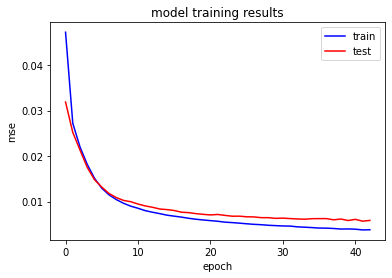

In [42]:
plot_loss(history)

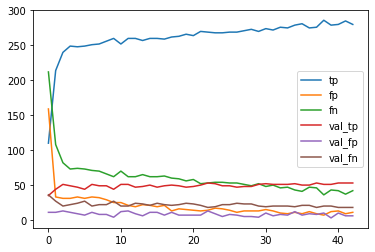

In [43]:
plot_metrics(history)

### check for testing results

In [31]:
test_data, test_label = testing.drop("Class",axis=1).values, testing.Class

In [32]:
test_pred_score = classifier.predict_proba(test_data,batch_size=batch_size).ravel()

In [33]:
test_evaluation = classifier.evaluate(test_data, test_label, batch_size=batch_size)

223/223 [==============================] - 0s 2ms/step - loss: 0.0078 - tp: 72.0000 - fp: 7.0000 - fn: 27.0000


In [34]:
for thr in np.arange(0.4,0.62,0.02):
    print(thr)
    model_results(test_label,test_pred_score,threshold=thr,ifprint=True)

0.4
[[56855     8]
 [   24    75]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.90      0.76      0.82        99

    accuracy                           1.00     56962
   macro avg       0.95      0.88      0.91     56962
weighted avg       1.00      1.00      1.00     56962

0.42000000000000004
[[56855     8]
 [   25    74]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.90      0.75      0.82        99

    accuracy                           1.00     56962
   macro avg       0.95      0.87      0.91     56962
weighted avg       1.00      1.00      1.00     56962

0.44000000000000006
[[56856     7]
 [   25    74]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.91      0.75      0.82        99

    accuracy                           1.00  